
## https://challenge.isic-archive.com/data/

# II. code

In [1]:
import os
import cv2
import glob
import torch
import shutil
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation

## 1. load model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'model/segmentation/modelSegformer_best.pth'
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512").to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## 2. Define fuction

In [3]:
def find_bbox_from_mask(mask):
    """
    mask: numpy array (H, W)
    """
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(contour)
        return x, y, w, h

def convert_bbox_size(x,y,w,h,mask_size, image_size, padding =(0,0)):
    """
    x,y,w,h: bbox size in mask
    mask_size: size of mask
    image_size: size of image
    """
    x_new = int((x*image_size[1])/mask_size[1]) - padding[0]
    y_new = int((y*image_size[0])/mask_size[0]) - padding[1]
    w_new = int((w*image_size[1])/mask_size[1]) + padding[0]*2
    h_new = int((h*image_size[0])/mask_size[0]) + padding[1]*2

    # check if bbox out of image
    if x_new < 0:
        x_new = 0
    if y_new < 0:
        y_new = 0

    if x_new + w_new > image_size[1]:
        w_new = image_size[1]
    if y_new + h_new > image_size[0]:
        h_new = image_size[0]

    return x_new, y_new, w_new, h_new

def check_image_new_size(w,h):
    # w,h << 50px -> not enough information
    if w == 0 or h == 0:
        return False
    if w < 50 or h < 50:
        return False
    #w = h*5 or h = w*5 -> not enough information
    elif w/h > 4 or h/w > 4:
        return False
    else:
        return True

def create_new_image(path_image, test_transform ,padding_percent):
    image = cv2.imread(path_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_original = image.copy()
    shape_original = image.shape
    image = test_transform(image=image)['image'].unsqueeze(0).to(device)
    image_mask_original = np.zeros((shape_original[0], shape_original[1]))

    with torch.no_grad():
        y_hat = model(image.to(device))
        y_hat = y_hat.logits
        y_hat =  F.interpolate(y_hat, size=(trainsize,trainsize), mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()
        image_mask_original = cv2.resize(y_hat, (shape_original[1], shape_original[0]), interpolation=cv2.INTER_NEAREST)

    x, y, w, h = find_bbox_from_mask(y_hat)
    x_img, y_img, w_img, h_img = convert_bbox_size(x,y,w,h,(trainsize,trainsize), \
                                                            shape_original,        \
                                                            padding=(int(padding_percent[0]*shape_original[0]/100),int( padding_percent[1]*shape_original[1]/100)))

    new_image = image_original[y_img:y_img+h_img, x_img:x_img+w_img]
                        
    if check_image_new_size(new_image.shape[1], new_image.shape[0]):
        return new_image, image_mask_original
    else:
        return image_original, image_mask_original

def create_new_dataset(path_original, path_new, test_transform, padding_percent=(4,4)):
    count = 0
    list_image_error = []
    image_names = glob.glob(path_original+'/*.jpg')
    for i, path in enumerate(tqdm(image_names)):
        name = path.split('/')[-1]
        try:
            new_image, image_mask_original = create_new_image(path, test_transform, padding_percent)
            new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(path_new,name), new_image)
        except:
            count += 1
            list_image_error.append(name)
            shutil.copy(path, os.path.join(path_new,name))
    
    return count, list_image_error


def create_mask_dataset(path_original, path_new, test_transform, padding_percent=(4,4)):
    count = 0
    list_image_error = []
    image_names = glob.glob(path_original+'/*.jpg')
    for i, path in enumerate(tqdm(image_names)):
        name = path.split('/')[-1]
        try:
            new_image, image_mask_original = create_new_image(path, test_transform, padding_percent)
            image_mask_original = image_mask_original*255
            cv2.imwrite(os.path.join(path_new,name), image_mask_original)
        except:
            # if error shave in error folder
            if not os.path.exists(os.path.join(path_new,'error')):
                os.makedirs(os.path.join(path_new,'error'))
            count += 1
            list_image_error.append(name)
            shutil.copy(path, os.path.join(path_new,'error',name))
        
    
    return count, list_image_error

## 3. Check fuction

In [4]:
trainsize = 384
test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

(480, 635, 3)


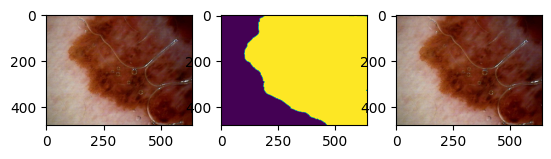

In [5]:
path_image = 'Data/ISIC2020/train/malignant_skin/ISIC_5758388.jpg'
new_image, image_mask_original = create_new_image(path_image, test_transform,padding_percent=(20,20))
print(new_image.shape)
plt.subplot(1,3,1)
plt.imshow(new_image)
plt.subplot(1,3,2)
plt.imshow(image_mask_original)
plt.subplot(1,3,3)
image_test = cv2.imread(path_image)
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
plt.imshow(image_test)
plt.show()

## 4. data processing

### 4.1 path dataset original

In [6]:
path_dataset_original = 'Data/ISIC2020'

path_dataset_original_train_target_0 = path_dataset_original + '/train/benign_skin'
path_dataset_original_train_target_1 = path_dataset_original + '/train/malignant_skin'

path_dataset_original_test_target_0 = path_dataset_original + '/test/benign_skin'
path_dataset_original_test_target_1 = path_dataset_original + '/test/malignant_skin'

In [7]:
padding_percent = (20,20)

### 4.2 path new dataset

In [8]:
path_dataset_new = 'Data/ISIC2020_Segment_Cropt'

path_dataset_new_train_target_0 = path_dataset_new + '/train/benign_skin'
path_dataset_new_train_target_1 = path_dataset_new + '/train/malignant_skin'

path_dataset_new_test_target_0 = path_dataset_new + '/test/benign_skin'
path_dataset_new_test_target_1 = path_dataset_new + '/test/malignant_skin'

In [9]:
import os
if not os.path.exists(path_dataset_new):
    os.mkdir(path_dataset_new)
    os.mkdir(path_dataset_new + '/train')
    os.mkdir(path_dataset_new + '/test')
    os.mkdir(path_dataset_new_train_target_0)
    os.mkdir(path_dataset_new_train_target_1)
    os.mkdir(path_dataset_new_test_target_0)
    os.mkdir(path_dataset_new_test_target_1)

### 4.3 process testset

In [10]:
trainsize = 384
test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

#### target 0

In [11]:
padding_percent = (15,15)

In [12]:
path_original = path_dataset_original_test_target_0
path_new = path_dataset_new_test_target_0

In [13]:
print('path_original:', path_original)
print('path_new:', path_new)
create_new_dataset(path_original, path_new, test_transform, padding_percent=padding_percent)

path_original: Data/ISIC2020/test/benign_skin
path_new: Data/ISIC2020_Segment_Cropt/test/benign_skin


100%|██████████| 6509/6509 [29:43<00:00,  3.65it/s]


(3, ['ISIC_0363251.jpg', 'ISIC_4532303.jpg', 'ISIC_7803496.jpg'])

#### target 1

In [14]:
padding_percent = (40,40)

In [15]:
path_original = path_dataset_original_test_target_1
path_new = path_dataset_new_test_target_1
print('path_original:', path_original)
print('path_new:', path_new)
create_new_dataset(path_original, path_new, test_transform, padding_percent=padding_percent)

path_original: Data/ISIC2020/test/malignant_skin
path_new: Data/ISIC2020_Segment_Cropt/test/malignant_skin


100%|██████████| 117/117 [00:26<00:00,  4.40it/s]


(0, [])

### 4.4 process trainset

In [16]:
trainsize = 384
train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

#### target 0

In [17]:
padding_percent = (15,15)

In [18]:
path_original = path_dataset_original_train_target_0
path_new = path_dataset_new_train_target_0
print('path_original:', path_original)
print('path_new:', path_new)
create_new_dataset(path_original, path_new, train_transform, padding_percent=padding_percent)

path_original: Data/ISIC2020/train/benign_skin
path_new: Data/ISIC2020_Segment_Cropt/train/benign_skin


100%|██████████| 26033/26033 [1:55:42<00:00,  3.75it/s]  


(10,
 ['ISIC_9621586.jpg',
  'ISIC_3365320.jpg',
  'ISIC_4328501.jpg',
  'ISIC_7477593.jpg',
  'ISIC_8150469.jpg',
  'ISIC_0568828.jpg',
  'ISIC_5863192.jpg',
  'ISIC_7067750.jpg',
  'ISIC_1260198.jpg',
  'ISIC_7179363.jpg'])

#### target 1

In [19]:
padding_percent = (40,40)

In [20]:
path_original = path_dataset_original_train_target_1
path_new = path_dataset_new_train_target_1
print('path_original:', path_original)
print('path_new:', path_new)
create_new_dataset(path_original, path_new, train_transform, padding_percent=padding_percent)

path_original: Data/ISIC2020/train/malignant_skin
path_new: Data/ISIC2020_Segment_Cropt/train/malignant_skin


100%|██████████| 467/467 [01:32<00:00,  5.04it/s]


(0, [])

In [21]:
len(glob.glob('Data/ISIC2020_Augment/train/malignant_skin/*'))

0